In [1]:
import sys
sys.path.append('nam')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch

In [4]:
from itertools import combinations

In [5]:
from scipy import stats

In [6]:
import numpy as np
import pandas as pd
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import random_split

from nam.wrapper import NAMClassifier, MultiTaskNAMClassifier

/mnt/idms/kdomokos/ericcson/rishap/supplementary/nam/nam/nam/trainer/trainer.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
random_state = 2016

In [8]:
import data_utils
data_x, data_y, columns = data_utils.load_dataset("Recidivism")
original_dfs = data_utils.load_recidivism_data()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=random_state)

In [10]:
device="cuda:7"

In [11]:
%%time
single_models = []
for i in range(len(columns)):
    X_train_f = X_train[:, i:i+1]
    X_test_f = X_test[:, i:i+1]
    model = NAMClassifier(
        num_epochs=1000,
        num_learners=20,
        metric='auroc',
        early_stop_mode='max',
        monitor_loss=False,
        n_jobs=10,
        random_state=random_state,
        device=device
    )

    model.fit(X_train_f, y_train)
    pred = model.predict_proba(X_test_f)
    print(columns[i], sk_metrics.roc_auc_score(y_test, pred))
    single_models.append(model)

age 0.6012683218346646
race 0.5735968155891
sex 0.5393249134264966
priors_count 0.6194020692267879
length_of_stay 0.5006402970978534
c_charge_degree 0.5686478526036081
CPU times: user 57.6 s, sys: 6.74 s, total: 1min 4s
Wall time: 1min 55s


In [12]:
%%time
one_out_models = []
ixs = np.arange(len(columns))
for i in range(len(columns)):
    ixs_f = ixs[np.where(ixs!=i)]
    
    X_train_f = X_train[:, ixs_f]
    X_test_f = X_test[:, ixs_f]
    model = NAMClassifier(
        num_epochs=1000,
        num_learners=20,
        metric='auroc',
        early_stop_mode='max',
        monitor_loss=False,
        n_jobs=10,
        random_state=random_state,
        device=device
    )

    model.fit(X_train_f, y_train)
    pred = model.predict_proba(X_test_f)
    print(columns[i], sk_metrics.roc_auc_score(y_test, pred))
    one_out_models.append(model)

age 0.6868520326764952
race 0.7425338690485718
sex 0.7376622752957372
priors_count 0.6621792511725441
length_of_stay 0.7396552000128058
c_charge_degree 0.7385426838052856
CPU times: user 1min 37s, sys: 7.18 s, total: 1min 44s
Wall time: 6min 39s


In [13]:
%%time
full_model = NAMClassifier(
    num_epochs=1000,
    num_learners=20,
    metric='auroc',
    early_stop_mode='max',
    monitor_loss=False,
    n_jobs=10,
    random_state=random_state,
    device=device
)

full_model.fit(X_train, y_train)
pred = full_model.predict_proba(X_test)
sk_metrics.roc_auc_score(y_test, pred)

CPU times: user 17.3 s, sys: 1.2 s, total: 18.5 s
Wall time: 59.8 s


0.7447055433721246

In [14]:
full_logit = super(NAMClassifier, full_model).predict(X_test)
single_logits = [super(NAMClassifier, m).predict(X_test[:,[i]]) for i, m in enumerate(single_models)]
one_out_logits = [super(NAMClassifier, m).predict(X_test[:,ixs[np.where(ixs!=i)]]) for i, m in enumerate(one_out_models)]

In [15]:
full_model_part_logits = []
for i, col in enumerate(columns):
    X = np.zeros_like(X_test)
    X[:, i] = X_test[:, i]
    full_model_part_logits.append(super(NAMClassifier, full_model).predict(X))

#### auc scores as predicted by single variable models

In [16]:
for i, pred in enumerate(single_logits):
    print(columns[i], sk_metrics.roc_auc_score(y_test, pred))

age 0.6049793770976399
race 0.5492948728209889
sex 0.5537956278379834
priors_count 0.6331551173077641
length_of_stay 0.502022271667387
c_charge_degree 0.5567943525795969


#### auc scores as predicted by leave-one-out models

In [17]:
for i, pred in enumerate(one_out_logits):
    print(columns[i], sk_metrics.roc_auc_score(y_test, pred))

age 0.6936125028679974
race 0.7420242992748635
sex 0.7388708360679355
priors_count 0.6595353577393244
length_of_stay 0.736763191454168
c_charge_degree 0.7390442498652708


#### auc scores as predicted by parts of the full_model

In [18]:
for i, pred in enumerate(full_model_part_logits):
    print(columns[i], sk_metrics.roc_auc_score(y_test, pred))

age 0.5963380341811935
race 0.5363555356352013
sex 0.5278956102298132
priors_count 0.6770394796518919
length_of_stay 0.5016941194047372
c_charge_degree 0.5511730776413589


In [19]:
# mostly priors count! interesting

In [20]:
def var(x):
    return np.mean((x-x.mean())**2)

In [21]:
full_var = var(full_logit)
full_var

0.20494473660298185

In [22]:
for i,sl in enumerate(single_logits):
    print(columns[i], var(sl-full_logit)/full_var)

age 0.9580647697074611
race 0.9639986575391462
sex 0.9807835838694217
priors_count 0.9575788535784228
length_of_stay 1.0003568508018872
c_charge_degree 0.9656140922384735


In [23]:
for i,sl in enumerate(one_out_logits):
    print(columns[i], var(sl-full_logit)/full_var)

age 0.25584574365199125
race 0.11671478943215319
sex 0.06367562979836833
priors_count 0.5386212257260354
length_of_stay 0.03860360357017689
c_charge_degree 0.07618417463757282


In [24]:
# much better than previous attemps! interesting, without the priors count, again it performs _very_ bad

# visualize (marginalized) feature contributions as last feature vs part of ensamble

In [25]:
full_logit_train = super(NAMClassifier, full_model).predict(X_train)

In [26]:
full_model_part_logits_train = []
for i, col in enumerate(columns):
    X = np.zeros_like(X_train)
    X[:, i] = X_train[:, i]
    full_model_part_logits_train.append(super(NAMClassifier, full_model).predict(X))

In [27]:
one_out_logits_train = [super(NAMClassifier, m).predict(X_train[:,ixs[np.where(ixs!=i)]]) for i, m in enumerate(one_out_models)]

In [28]:
def special_step(*args, **kwargs):
    x,y,*z = args
    x0 = 2*x[0]-x[1]
    xn = 2*x[-1]-x[-2]
    xx = np.concatenate([[x0], x, [xn]])
    yy = np.concatenate([[y[0]], y, [y[-1]]])
    plt.step(xx, yy, *z, **kwargs)
    plt.xlim((xx[0]+xx[1])/2, (xx[-2]+xx[-1])/2)

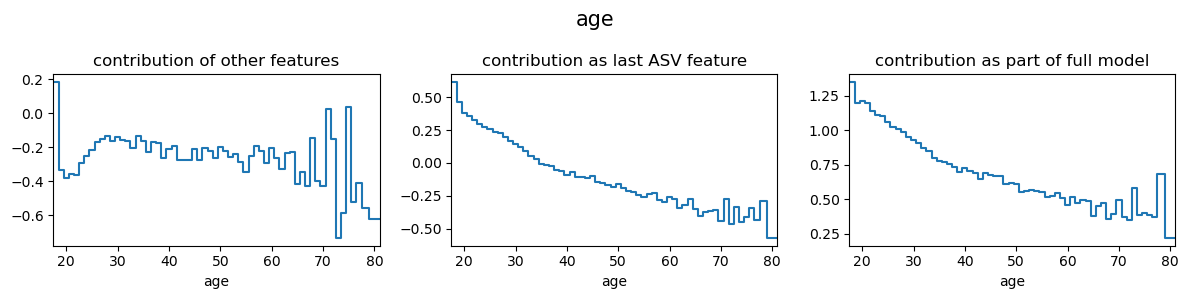

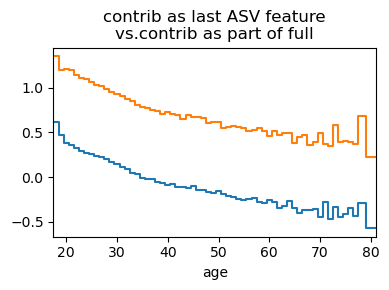

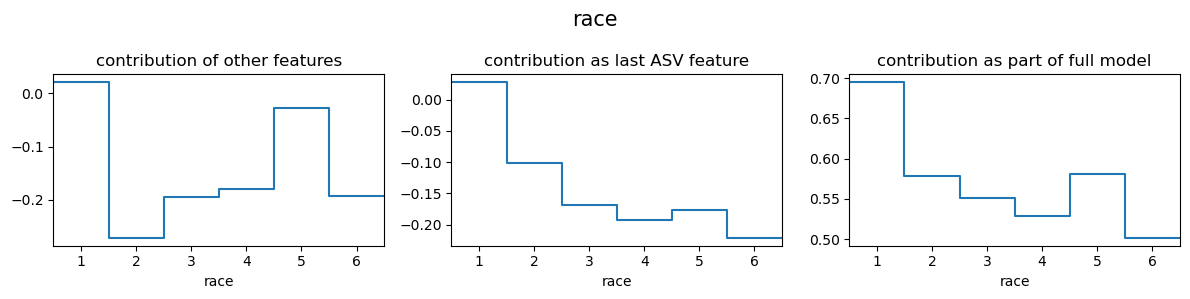

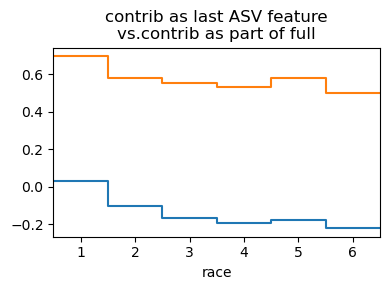

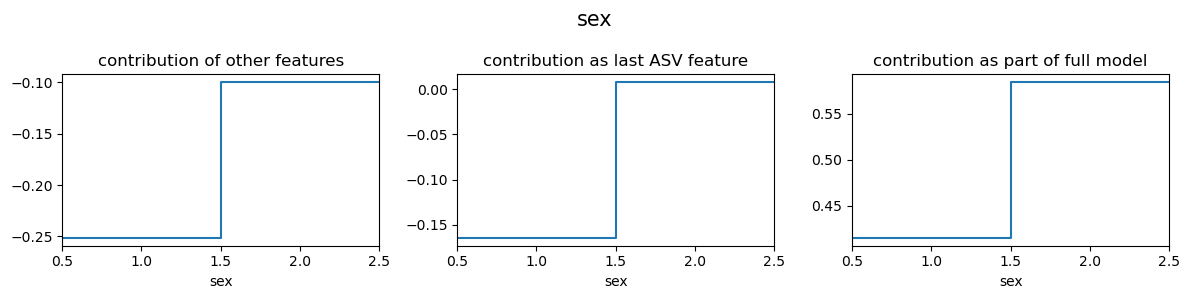

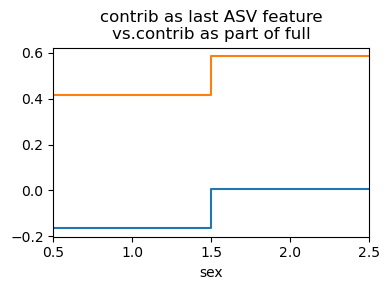

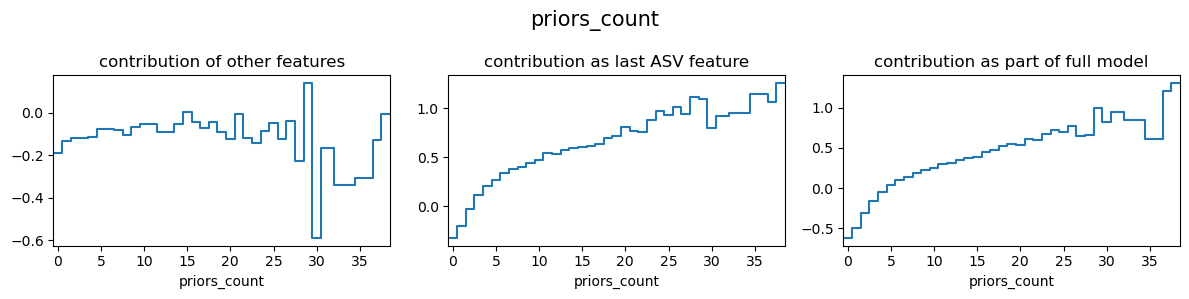

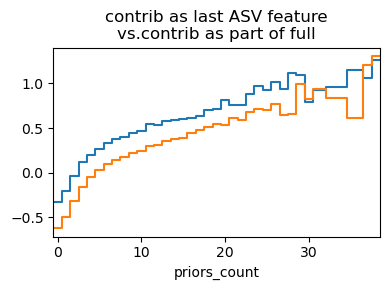

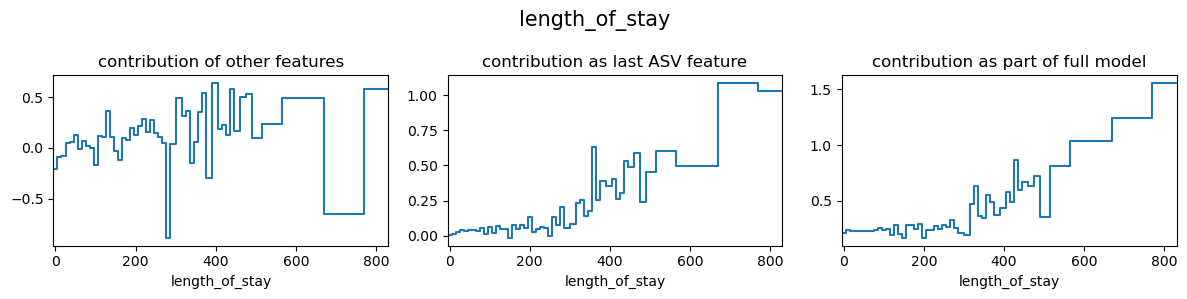

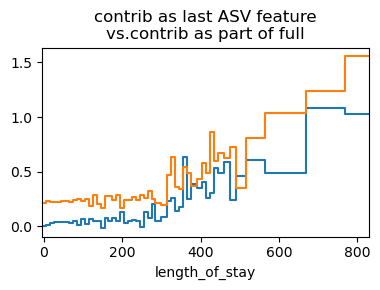

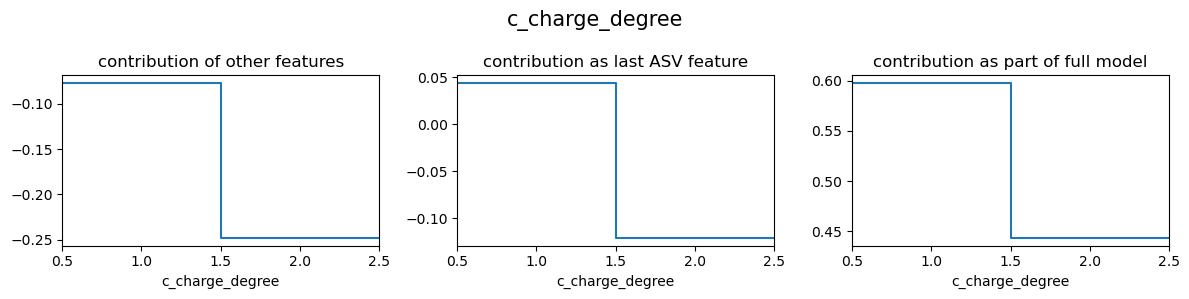

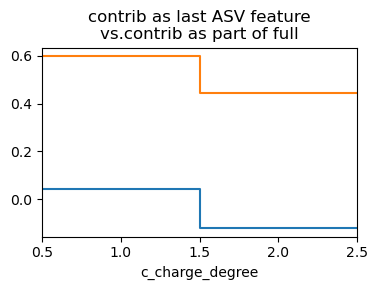

In [30]:
with torch.no_grad():
    for i, colname in zip(range(len(columns)), columns):
        plt.figure(figsize=(12,3))
        plt.suptitle(colname, fontsize=15)
        
        # leave-one-out model
        valmap = dict(zip(data_x[:,i], original_dfs['X'][columns[i]]))
        pred_df = pd.DataFrame({'X': X_train[:,i], 'pred': one_out_logits_train[i]})
        pred_df['X_orig'] = pred_df['X'].map(valmap)
        to_plot_1 = pred_df.groupby('X_orig')['pred'].mean()
        if i==4:
            to_plot_1 = pred_df.groupby((pred_df['X_orig']//10)*10)['pred'].mean()
 
        plt.subplot(1, 3, 1)
        plt.title('contribution of other features')
        plt.xlabel(colname)
        special_step(to_plot_1.index, to_plot_1.values, where='mid')
        
        
        # feature contrib as last
        
        valmap = dict(zip(data_x[:,i], original_dfs['X'][columns[i]]))
        pred_df = pd.DataFrame({'X': X_train[:,i], 'pred': full_logit_train-one_out_logits_train[i]})
        pred_df['X_orig'] = pred_df['X'].map(valmap)
        to_plot_2 = pred_df.groupby('X_orig')['pred'].mean()
        if i==4:
            to_plot_2 = pred_df.groupby((pred_df['X_orig']//10)*10)['pred'].mean()
 
        plt.subplot(1, 3, 2)
        plt.title('contribution as last ASV feature')
        plt.xlabel(colname)
        special_step(to_plot_2.index, to_plot_2.values, where='mid')
        
        
        # feature contrib as part of ensamble
        
        valmap = dict(zip(data_x[:,i], original_dfs['X'][columns[i]]))
        pred_df = pd.DataFrame({'X': X_train[:,i], 'pred': full_model_part_logits_train[i]})
        pred_df['X_orig'] = pred_df['X'].map(valmap)
        to_plot_3 = pred_df.groupby('X_orig')['pred'].mean()
        if i==4:
            to_plot_3 = pred_df.groupby((pred_df['X_orig']//10)*10)['pred'].mean()
        
        plt.subplot(1, 3, 3)
        plt.title('contribution as part of full model')
        plt.xlabel(colname)
        special_step(to_plot_3.index, to_plot_3.values, where='mid')
        
        plt.subplots_adjust(top=0.7)
        plt.tight_layout()
        plt.savefig("out/leave_one_out_%d.png"%i)
        
        
        plt.figure(figsize=(4,3))
        plt.title("contrib as last ASV feature\nvs.contrib as part of full")
        special_step(to_plot_2.index, to_plot_2.values, where='mid')
        special_step(to_plot_3.index, to_plot_3.values, where='mid')
        plt.xlabel(colname)
        plt.tight_layout()
        plt.savefig("out/leave_one_out_compare_%d.png"%i)